In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import pandas as pd
import shutil
from collections import defaultdict

# Set GPU memory growth to avoid allocating all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU devices and enabled memory growth")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")


SEED = 3888
def set_seed(seed=3888):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(SEED)

Found 1 GPU devices and enabled memory growth


In [5]:
# Define cell group mapping
cell_group_map = {
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",

    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

    # Unlabeled
    "Unlabeled": "Unlabeled"
}

# Define cancer and non-cancer cell type mapping
is_cancer_cell = {
    # Cancer cells (labeled as 1)
    "Prolif_Invasive_Tumor": 1,  # Tumor
    "Invasive_Tumor": 1,         # Tumor
    "DCIS_1": 1,                 # Early stage cancer
    "DCIS_2": 1,                 # Early stage cancer
    "T_Cell_and_Tumor_Hybrid": 1, # Tumor hybrid
    
    # Non-cancer cells (labeled as 0)
    "CD4+_T_Cells": 0,          # Immune
    "CD8+_T_Cells": 0,          # Immune
    "B_Cells": 0,               # Immune
    "IRF7+_DCs": 0,             # Immune
    "LAMP3+_DCs": 0,            # Immune
    "Macrophages_1": 0,         # Immune
    "Macrophages_2": 0,         # Immune
    "Mast_Cells": 0,            # Immune
    "Stromal_and_T_Cell_Hybrid": 0, # Hybrid (without tumor component)
    "Stromal": 0,               # Connective tissue
    "Perivascular-Like": 0,      # Connective tissue
    "Myoepi_ACTA2+": 0,         # Connective tissue
    "Myoepi_KRT15+": 0,         # Connective tissue
    "Endothelial": 0,           # Endothelial
    "Unlabeled": 0              # Unlabeled (default as non-cancer)
}

# Define image size and batch size
IMG_SIZE = 224  # Standard input size for ResNet50
BATCH_SIZE = 32

## Extract the same number of images from different classes

In [2]:
def get_cell_images(quadrant_path):
    """Get all cell image paths from the specified quadrant"""
    cell_images = defaultdict(list)
    for cell_type in os.listdir(quadrant_path):
        if cell_type in cell_group_map:  # Ensure it's a valid cell type
            cell_type_path = os.path.join(quadrant_path, cell_type)
            if os.path.isdir(cell_type_path):
                for img in os.listdir(cell_type_path):
                    if img.endswith('.png'):
                        cell_images[cell_type].append(os.path.join(cell_type_path, img))
    return cell_images



In [3]:

def balanced_sampling_from_files(cell_images, n_samples=500):
    """Perform balanced sampling on image paths"""
    # Separate cancer and other cell types
    cancer_types = []
    other_types = []
    
    for cell_type in cell_images.keys():
        if cell_group_map[cell_type] in ["Tumor", "Early stage cancer"]:
            cancer_types.append(cell_type)
        elif cell_group_map[cell_type] != "Unlabeled":
            other_types.append(cell_type)
    
    # Calculate number of samples for each type
    samples_per_cancer = n_samples // len(cancer_types) if cancer_types else 0
    samples_per_other = n_samples // len(other_types) if other_types else 0
    
    selected_images = []
    
    # Sample cancer cells
    for cell_type in cancer_types:
        images = cell_images[cell_type]
        n_select = min(samples_per_cancer, len(images))
        selected_images.extend(np.random.choice(images, n_select, replace=False))
    
    # Sample other cells
    for cell_type in other_types:
        images = cell_images[cell_type]
        n_select = min(samples_per_other, len(images))
        selected_images.extend(np.random.choice(images, n_select, replace=False))
    
    return selected_images

In [7]:
# Process each quadrant
input_base = "images/images_4fold"
output_base = "images/balanced_samples"

for quadrant in ["Q1", "Q2", "Q3", "Q4"]:
    print(f"\nProcessing quadrant {quadrant}...")
    
    # Get all images from current quadrant
    quadrant_path = os.path.join(input_base, quadrant)
    cell_images = get_cell_images(quadrant_path)
    print(len(cell_images))
    # Perform balanced sampling
    selected_images = balanced_sampling_from_files(cell_images)
    
    # Copy selected images
    for src_path in selected_images:
        # Maintain the same directory structure
        rel_path = os.path.relpath(src_path, quadrant_path)
        dst_path = os.path.join(output_base, quadrant, rel_path)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)
    
    # Print statistics
    print(f"Selected {len(selected_images)} images")
    cell_type_counts = defaultdict(int)
    for img_path in selected_images:
        cell_type = os.path.basename(os.path.dirname(img_path))
        cell_type_counts[cell_type] += 1
    
    for cell_type, count in sorted(cell_type_counts.items()):
        print(f"{cell_type}: {count}")


Processing quadrant Q1...
20
Selected 884 images
B_Cells: 33
CD4+_T_Cells: 33
CD8+_T_Cells: 33
DCIS_1: 14
DCIS_2: 125
Endothelial: 33
IRF7+_DCs: 33
Invasive_Tumor: 125
LAMP3+_DCs: 33
Macrophages_1: 33
Macrophages_2: 33
Mast_Cells: 33
Myoepi_ACTA2+: 33
Myoepi_KRT15+: 33
Perivascular-Like: 33
Prolif_Invasive_Tumor: 125
Stromal: 33
Stromal_and_T_Cell_Hybrid: 33
T_Cell_and_Tumor_Hybrid: 33

Processing quadrant Q2...
20
Selected 884 images
B_Cells: 33
CD4+_T_Cells: 33
CD8+_T_Cells: 33
DCIS_1: 14
DCIS_2: 125
Endothelial: 33
IRF7+_DCs: 33
Invasive_Tumor: 125
LAMP3+_DCs: 33
Macrophages_1: 33
Macrophages_2: 33
Mast_Cells: 33
Myoepi_ACTA2+: 33
Myoepi_KRT15+: 33
Perivascular-Like: 33
Prolif_Invasive_Tumor: 125
Stromal: 33
Stromal_and_T_Cell_Hybrid: 33
T_Cell_and_Tumor_Hybrid: 33

Processing quadrant Q2...
20
Selected 869 images
B_Cells: 33
CD4+_T_Cells: 33
CD8+_T_Cells: 33
DCIS_1: 125
DCIS_2: 125
Endothelial: 33
IRF7+_DCs: 33
Invasive_Tumor: 125
LAMP3+_DCs: 33
Macrophages_1: 33
Macrophages_2: 33

## Model Training

In [6]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0
    
    return img_array

In [8]:
def load_data_by_quandrant(dir, quardrants, target_size=(224, 224)):
    X_data = []
    y_data = []
    

    for quadrant in quardrants:
        quadrant_path = os.path.join(dir, quadrant)
        X_data_quadrant = []
        y_data_quadrant = []
        
        for cell_type in os.listdir(quadrant_path):
            cell_type_path = os.path.join(quadrant_path, cell_type)
            # print(f"Processing quadrant: {quadrant}, cell type: {cell_type}")
            
            if os.path.isdir(cell_type_path):
                for filename in os.listdir(cell_type_path):
                    if filename.endswith(".png") or filename.endswith(".jpg"):
                        img_path = os.path.join(cell_type_path, filename)
                        img = preprocess_image(img_path, target_size=target_size)
                        # print(img.shape)
                        # print(is_cancer_cell[cell_type])
                        # print(f"Processing image: {img_path}\n")
                        
                        X_data_quadrant.append(img)
                        y_data_quadrant.append(is_cancer_cell[cell_type])  
                        
        X_data.append(np.array(X_data_quadrant))
        y_data.append(np.array(y_data_quadrant))

    
    return (X_data, y_data)


In [ ]:
def create_resnet_model(learning_rate=0.001, input_shape=(224, 224, 3), seed=3888):
    # Clear any previous models in memory
    K.clear_session()
    
    # Set the random seed for reproducibility
    set_seed(seed)
    
    # Load the pre-trained ResNet50 model as the base model (without the top classification layers)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the weights of the base model so they are not updated during training
    base_model.trainable = False
    
    # Create the input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # Pass the input through the base model
    x = base_model(inputs, training=False)
    
    # Add a Global Average Pooling layer to reduce the spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)
    
    # Add a fully connected (Dense) layer with 256 units and ReLU activation
    x = layers.Dense(256, activation='relu')(x)
    
    # Add a Dropout layer to prevent overfitting
    x = layers.Dropout(0.5)(x)
    
    # Add the final output layer with 2 units for binary classification, using softmax activation
    outputs = layers.Dense(2, activation='softmax')(x)
    
    # Build the complete model
    model = models.Model(inputs, outputs)
    
    # Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy as a metric
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    return model


In [10]:
def quandrant_cv_resnet(X_datas, y_datas, epochs=10, batch_size=16, learning_rate=0.001):
    # Ensure input data is correct
    assert len(X_datas) == 4, "Need to provide X data for 4 quadrants"
    assert len(y_datas) == 4, "Need to provide y data for 4 quadrants"
    
    # Define quadrant names
    quadrant_names = ["Q1", "Q2", "Q3", "Q4"]
    
    # Save results
    results = {
        'accuracies': [],
        'f1_scores': [],
        'auc_scores': [],
        'confusion_matrices': [],
        'histories': [],
        'test_quadrants': [],
        'y_true': [],
        'y_pred': [],
        'y_prob': []
    }
    
    # Perform leave-one-out cross validation for each quadrant
    for test_idx in range(4):
        print(f"\n=== Fold {test_idx+1} Cross Validation - Test Quadrant: {quadrant_names[test_idx]} ===")
        
        # Select test set
        X_test = X_datas[test_idx]
        y_test = y_datas[test_idx]
        
        # Merge other three quadrants as training set
        train_indices = [i for i in range(4) if i != test_idx]
        X_train = np.concatenate([X_datas[i] for i in train_indices])
        y_train = np.concatenate([y_datas[i] for i in train_indices])
        
        # Convert to categorical labels
        y_train_cat = to_categorical(y_train, num_classes=2)
        y_test_cat = to_categorical(y_test, num_classes=2)
        
        print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
        print(f"Training set label distribution: {np.unique(y_train, return_counts=True)}")
        print(f"Test set label distribution: {np.unique(y_test, return_counts=True)}")
        
        # Create and train model
        model = create_resnet_model(
            learning_rate=learning_rate,
            seed=SEED
        )
        
        # Add early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            X_train, y_train_cat,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
        
        # Predict
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1)
        y_true = y_test
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate AUC
        try:
            fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
            auc_score = auc(fpr, tpr)
        except:
            auc_score = 0
            
        # Save results
        results['accuracies'].append(accuracy)
        results['f1_scores'].append(f1)
        results['auc_scores'].append(auc_score)
        results['confusion_matrices'].append(cm)
        results['histories'].append(history)
        results['test_quadrants'].append(quadrant_names[test_idx])
        results['y_true'].append(y_true)
        results['y_pred'].append(y_pred)
        results['y_prob'].append(y_prob)
        
        # Output evaluation metrics for current fold
        print(f"\nCurrent fold ({quadrant_names[test_idx]} as test set):")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print("Confusion Matrix:")
        print(cm)
        
        # Free memory
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        
    # Calculate average metrics
    avg_accuracy = np.mean(results['accuracies'])
    avg_f1 = np.mean(results['f1_scores'])
    avg_auc = np.mean(results['auc_scores'])
    
    print("\n=== Cross Validation Summary ===")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f"Average AUC: {avg_auc:.4f}")
    
    return results

In [11]:
def plot_cv_metrics(results):
    """Plot evaluation metrics for each CV fold"""
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # Accuracy
    ax[0].bar(results['test_quadrants'], results['accuracies'], color='skyblue')
    ax[0].axhline(y=np.mean(results['accuracies']), color='red', linestyle='--', label=f'Mean: {np.mean(results["accuracies"]):.4f}')
    ax[0].set_ylim([0, 1])
    ax[0].set_title('Test Accuracy per Fold')
    ax[0].set_xlabel('Test Quadrant')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    # F1 Score
    ax[1].bar(results['test_quadrants'], results['f1_scores'], color='lightgreen')
    ax[1].axhline(y=np.mean(results['f1_scores']), color='red', linestyle='--', label=f'Mean: {np.mean(results["f1_scores"]):.4f}')
    ax[1].set_ylim([0, 1])
    ax[1].set_title('Test F1 Score per Fold')
    ax[1].set_xlabel('Test Quadrant')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    
    # AUC Score
    ax[2].bar(results['test_quadrants'], results['auc_scores'], color='lightcoral')
    ax[2].axhline(y=np.mean(results['auc_scores']), color='red', linestyle='--', label=f'Mean: {np.mean(results["auc_scores"]):.4f}')
    ax[2].set_ylim([0, 1])
    ax[2].set_title('Test AUC Score per Fold')
    ax[2].set_xlabel('Test Quadrant')
    ax[2].set_ylabel('AUC')
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results):
    """Plot confusion matrices for each fold"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (cm, quadrant) in enumerate(zip(results['confusion_matrices'], results['test_quadrants'])):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Test Quadrant: {quadrant}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['Non-Cancer', 'Cancer'])
        axes[i].set_yticklabels(['Non-Cancer', 'Cancer'])
    
    plt.tight_layout()
    plt.show()

def plot_learning_curves(results):
    """Plot learning curves for each fold"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (history, quadrant) in enumerate(zip(results['histories'], results['test_quadrants'])):
        axes[i].plot(history.history['accuracy'], label='Training Accuracy')
        axes[i].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[i].set_title(f'Learning Curve - Quadrant {quadrant}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (history, quadrant) in enumerate(zip(results['histories'], results['test_quadrants'])):
        axes[i].plot(history.history['loss'], label='Training Loss')
        axes[i].plot(history.history['val_loss'], label='Validation Loss')
        axes[i].set_title(f'Loss Curve - Quadrant {quadrant}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()


In [12]:
# Run four-quadrant cross validation
# Get previously loaded data
X_datas, y_datas = load_data_by_quandrant("images/balanced_samples", ["q1", "q2", "q3", "q4"], target_size=(224, 224))

# Set training parameters
params = {
    'epochs': 10,          # Number of training epochs
    'batch_size': 12,      # Batch size
    'learning_rate': 0.001, # Learning rate
}

# Run cross validation
cv_results = quandrant_cv_resnet(
    X_datas=X_datas,
    y_datas=y_datas,
    **params
)


=== Fold 1 Cross Validation - Test Quadrant: Q1 ===
Training set shape: (2813, 224, 224, 3), Test set shape: (884, 224, 224, 3)
Training set label distribution: (array([0, 1]), array([1386, 1427], dtype=int64))
Test set label distribution: (array([0, 1]), array([462, 422], dtype=int64))
Training set shape: (2813, 224, 224, 3), Test set shape: (884, 224, 224, 3)
Training set label distribution: (array([0, 1]), array([1386, 1427], dtype=int64))
Test set label distribution: (array([0, 1]), array([462, 422], dtype=int64))
Epoch 1/10
Epoch 1/10
188/188 [==============================] - 14s 43ms/step - loss: 0.6924 - accuracy: 0.5667 - val_loss: 0.6861 - val_accuracy: 0.5222
Epoch 2/10
188/188 [==============================] - 14s 43ms/step - loss: 0.6924 - accuracy: 0.5667 - val_loss: 0.6861 - val_accuracy: 0.5222
Epoch 2/10
188/188 [==============================] - 6s 34ms/step - loss: 0.6612 - accuracy: 0.5960 - val_loss: 0.6738 - val_accuracy: 0.5648
Epoch 3/10
188/188 [=============

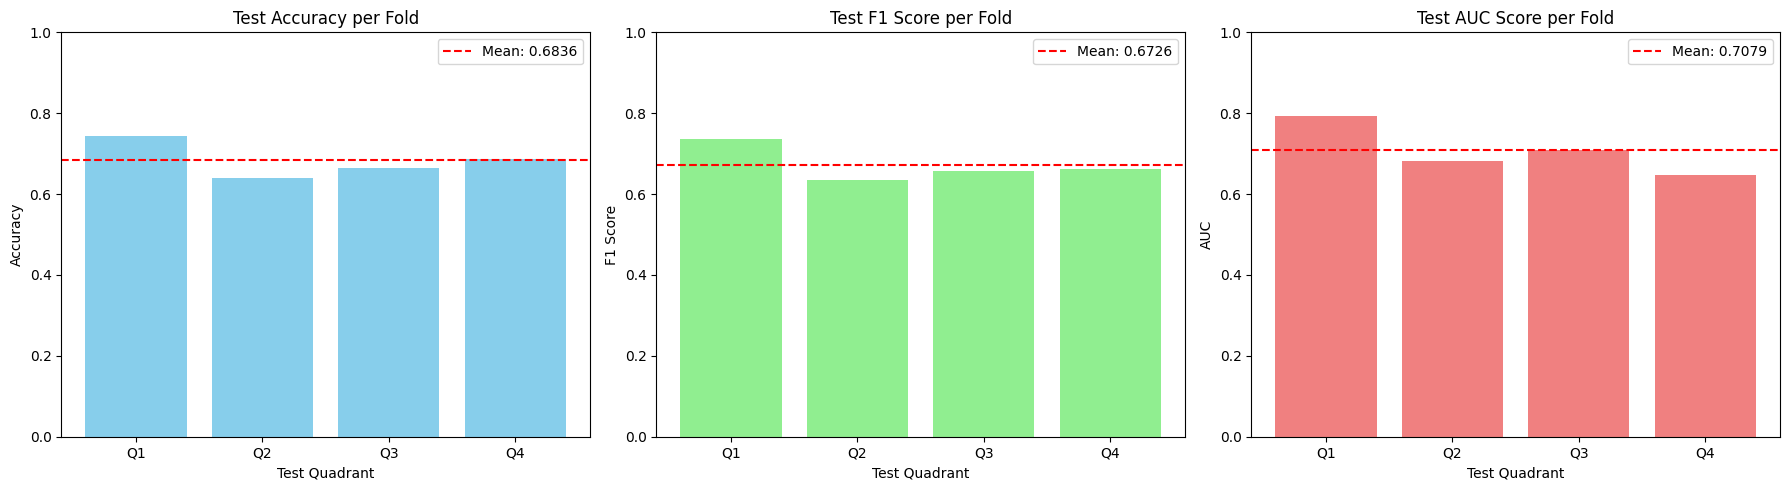

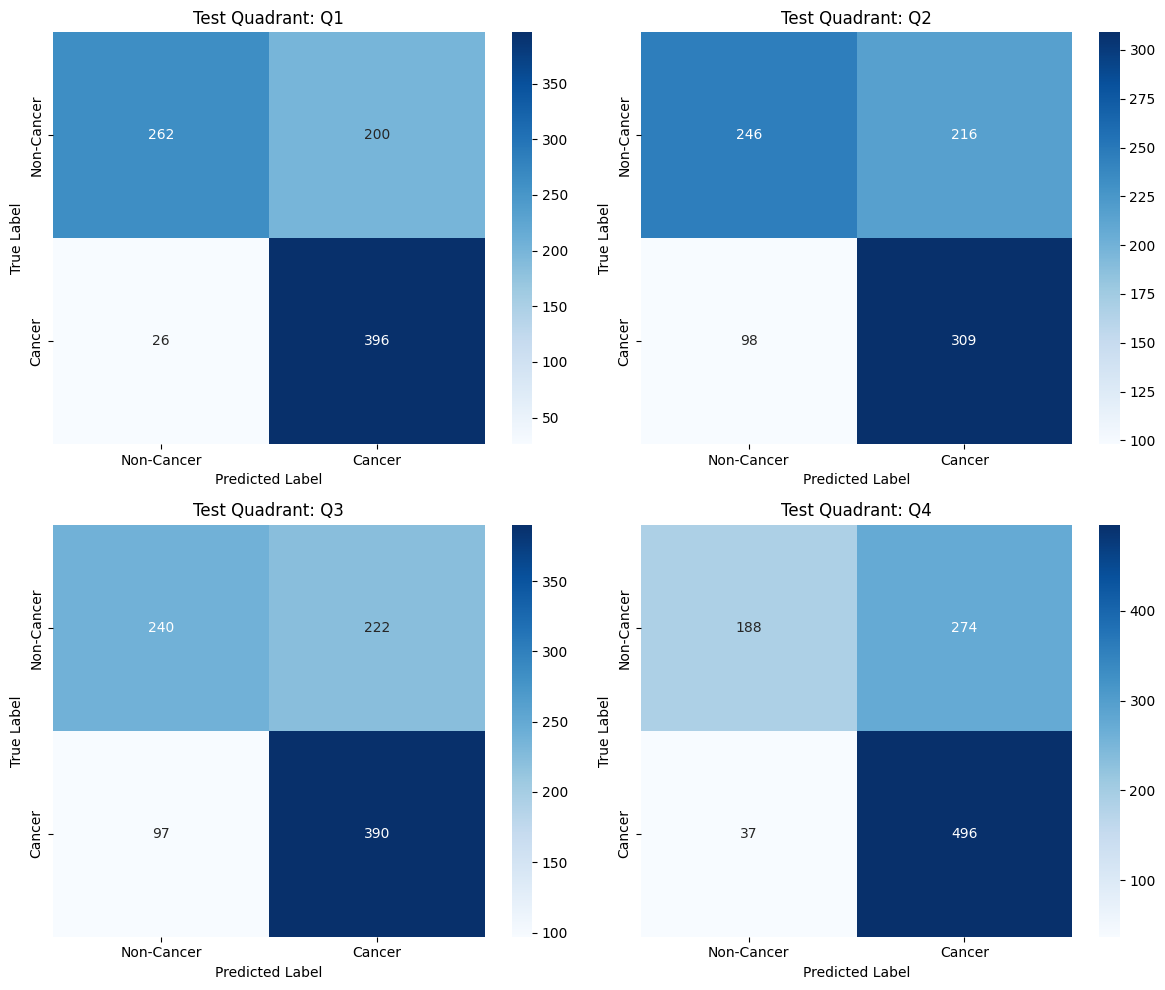

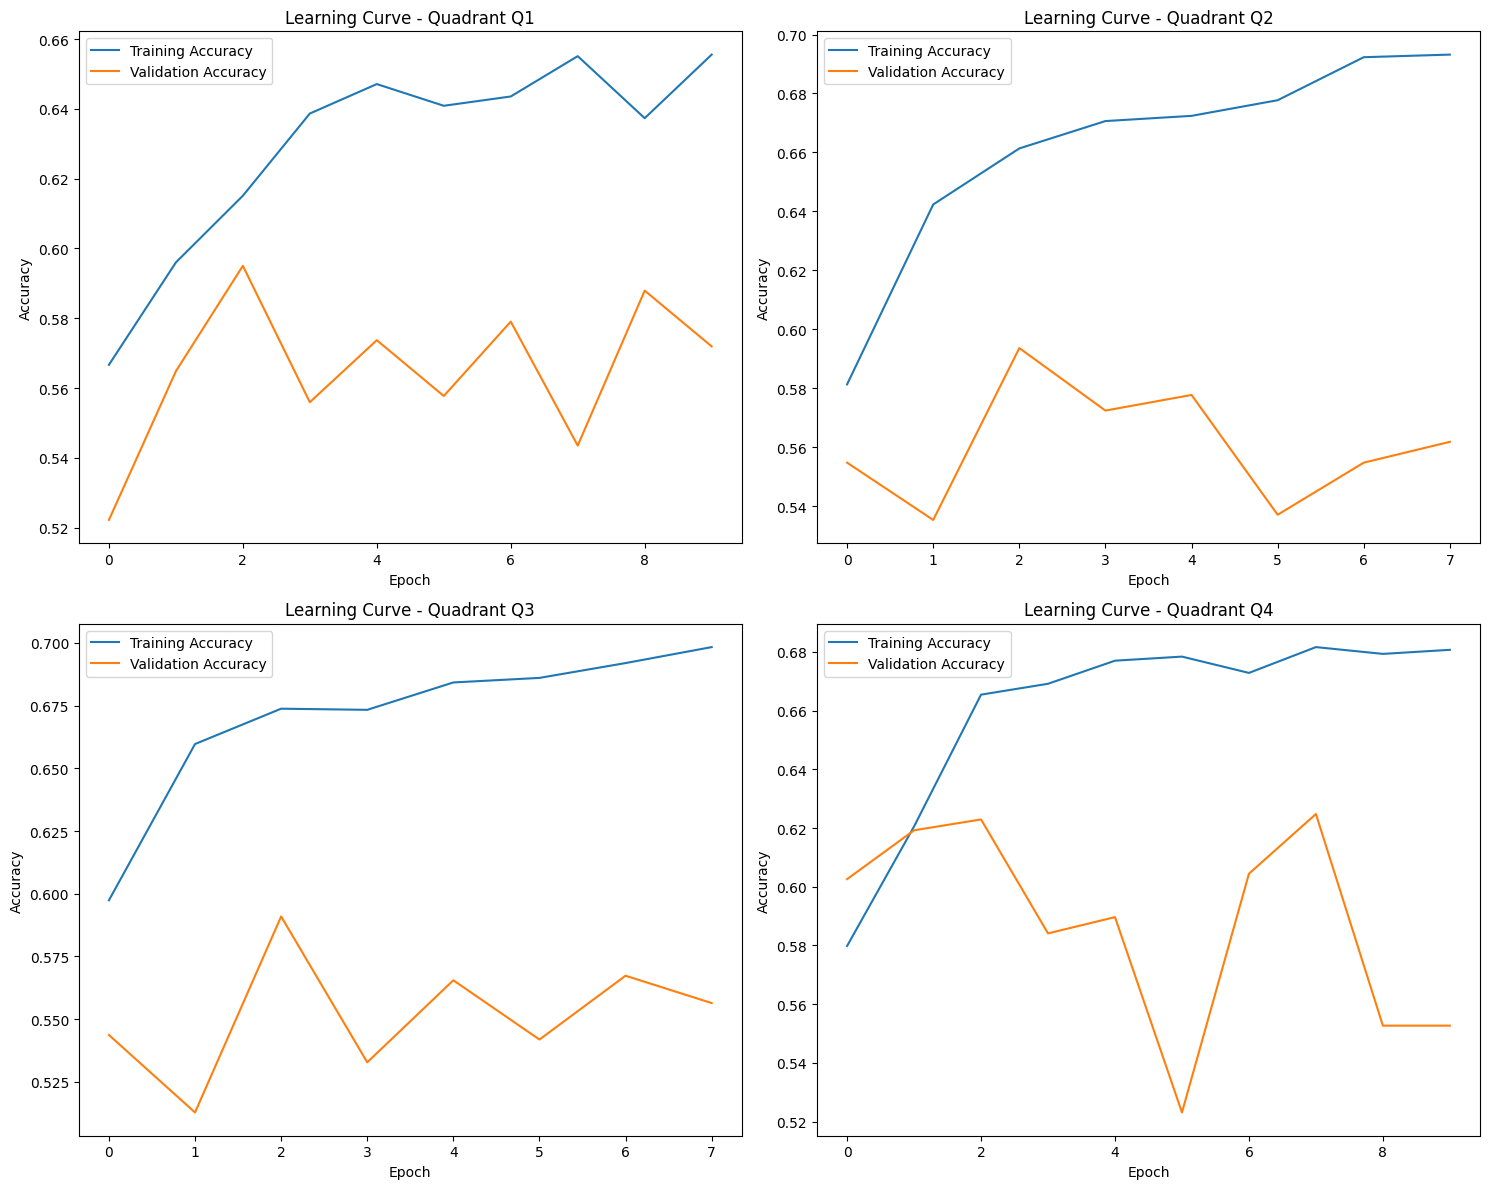

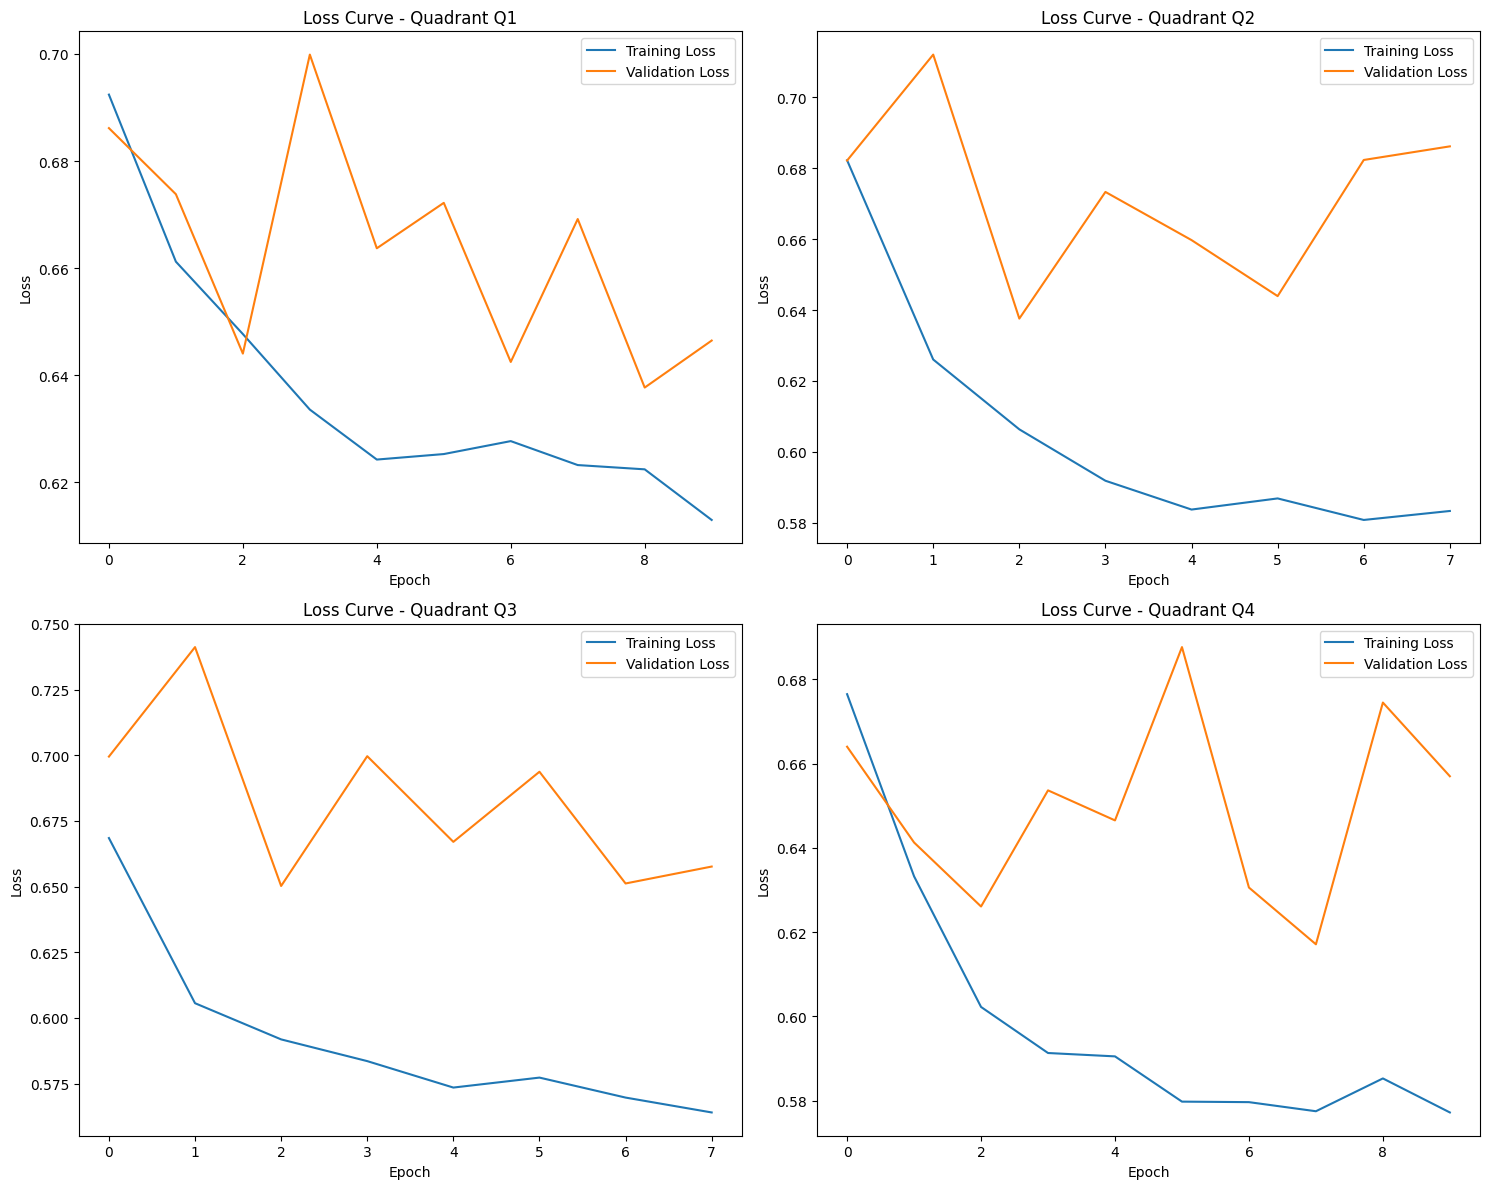

In [13]:
# Visualize cross validation results
plot_cv_metrics(cv_results)
plot_confusion_matrices(cv_results)
plot_learning_curves(cv_results)

In [14]:
# Save comprehensive cross validation report
def generate_classification_reports(results):
    """Generate classification reports for each test quadrant"""
    for i, quadrant in enumerate(results['test_quadrants']):
        print(f"\n=== Classification Report for Test Quadrant: {quadrant} ===")
        print(classification_report(results['y_true'][i], results['y_pred'][i], target_names=['Non-Cancer', 'Cancer']))
        
# Generate classification reports
generate_classification_reports(cv_results)


=== Classification Report for Test Quadrant: Q1 ===
              precision    recall  f1-score   support

  Non-Cancer       0.91      0.57      0.70       462
      Cancer       0.66      0.94      0.78       422

    accuracy                           0.74       884
   macro avg       0.79      0.75      0.74       884
weighted avg       0.79      0.74      0.74       884


=== Classification Report for Test Quadrant: Q2 ===
              precision    recall  f1-score   support

  Non-Cancer       0.72      0.53      0.61       462
      Cancer       0.59      0.76      0.66       407

    accuracy                           0.64       869
   macro avg       0.65      0.65      0.64       869
weighted avg       0.66      0.64      0.64       869


=== Classification Report for Test Quadrant: Q3 ===
              precision    recall  f1-score   support

  Non-Cancer       0.71      0.52      0.60       462
      Cancer       0.64      0.80      0.71       487

    accuracy           